# Gathering Data
This Jupyter notebook describes the process followed to obtain and cleanse the dataset used for the predictive model. 
This process is comprised of the following steps:

- **Step 1**: [Obtain audio clips from Broadcastify](#section_1)
- **Step 2**: [Convert all audio clips to 30sec segments with the command line and Audacity](#section_2)
- **Step 3**: [Feature extraction using Amazon Web Services](#section_3)
- **Step 4**: [Data merge and cleansing](#section_4)

## Step 1: Obtain audio clips from Broadcastify <a id="section_1"></a>
Given our problem statement we decided to download audio clips of various emergencies and non-emergencies from Broacastify. __[Broadcastify](https://www.broadcastify.com/about/)__ is the radio communications industry's largest platform for streaming live audio for public safety, aircraft, rail, and marine related communications. 

With a premium subscription Broadcastify allows you to access and download up to 180 days of archived recordings. 

**Positive class:** 

Positive classes in our model relate to various types of emergencies, ranging from shootings, to fires, to protests, etc. Broadcastify has an archive section called "LATEST NOTABLE ARCHIVES" which includes selcted audio from recent emergency situations. We initially took all of these archives as our starting positive class. Such files accounted for 8 hours and 49 minutes of audio.

We later supplemented the positive class with more audio files with audio clips of other emergencies from YouTube, which accounted for 3 hours of audio. 

**Negative class:**

Negative classes in our model relate to two main sources:
- Generic police chatter
- Incidents (non-emergencies)

Generic police chatter was downloaded from Broadcastify. We randomly picked 1 hour long clips of police Broadcast of the same cities as the positive class, listened to them, and filtered the ones that contained no incidents to be part of our negative class. Using this manual process we gathered 15 hours and 20 minutes of audio. 

Incidents (non-emergencies) were added to the negative class after making certain tests in the models (please refer to modelling noteboook). These audio clips account for 9 hours and 15 minutes of audio and they relate in nature to incidents that are not as severe to requiere a federal response (e.g - car chases, non-national emergency protests, arrests, etc.).

**Note** - Given the size of the raw data retrieved we were unable to host all the audio clips on git. If you wish to access these files please reach out to the authors (see readme). 

In the subsequent lines of code we briefly visualize the main characteristics of our raw data, as described above:

In [91]:
#Import libraries

import numpy as np
import pandas as pd
import regex as re
import matplotlib.pyplot as plt

#inline display command
%matplotlib inline


In [58]:
#Import the dataframe and display the characteristics of the raw data described above
df=pd.read_csv('df_master_audioandspeech_clean.csv')
df.drop(columns='Unnamed: 0',inplace=True)

In [ ]:
#Create pivot for bar plotting
table = pd.pivot_table(df,
                       index='class',
                       columns='origin',
                       values='emergency_type',
                       aggfunc=lambda x: len(x),
                       margins=True)

# table rename columns
table.rename(columns={'new_files':'Youtube',
                      'original_files':'Broadcastify'},inplace=True)


Note: Negative class clips from youtube relate soley to "Incidents (non-emergencies)" Negative classes from broadcastify relate soley to generic police chatter.


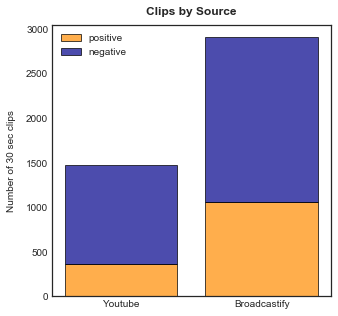

In [95]:
#Plot
plt.style.use('seaborn-white')
fig , ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5))

ax.bar(x=['Youtube','Broadcastify'],
            height=[table['Youtube']['positive'],
                    table['Broadcastify']['positive']],
           color='darkorange',
           edgecolor='k',
           alpha=0.7)

ax.bar(x=['Youtube','Broadcastify'],
            height=[table['Youtube']['negative'],
                    table['Broadcastify']['negative']],
           color='darkblue',
           edgecolor='k',
           alpha=0.7,
           bottom=[table['Youtube']['positive'],
                    table['Broadcastify']['positive']])

ax.set_title('Clips by Source',weight='bold',pad=10)
ax.set_ylabel('Number of 30 sec clips',labelpad=10)

ax.legend(['positive','negative'])
# plt.savefig("clips_by_source.svg", format="svg")

print('\nNote: Negative class clips from youtube relate soley to "Incidents (non-emergencies)"',
      'Negative classes from broadcastify relate soley to generic police chatter.');

In [90]:
#This table shows the actual #of audioclips
table

origin,Youtube,Broadcastify,All
class,,,
negative,1110,1840,2950
positive,360,1058,1418
All,1470,2898,4368


## Step 2: Convert all audio clips to 30sec segments with the command line and Audacity <a id="section_2"></a>

As explained above, we took clips from the described datasources and parsed them into 30 second clips in order to build the dataframe for the model. We did this through two main processes:

- Audacity
- Command line

We used the command line method to speed up the data gathering process in an Elastic Cloud (EC2) instance using Amazon Web Services (AWS). Depending on the readers knowledge on the use of AWS he can opt to use either method, the one that suits them best. That is why we describe both of them in this section.

**Audacity:** __[Audacity](https://www.audacityteam.org/about/)__ is a free, easy-to-use, multi-track audio editor and recorder for Windows, Mac OS X, GNU/Linux and other operating systems. Using this software we manually splitted the audio from step 1 into 30 second clips. We recommend the reader to watch this youtube video to understand the exact steps to carry out this task.

**Command line:** You can easily automate this process with the command line. We used this method to speed up the data gathering process in an Elastic Cloud (EC2) instance using Amazon Web Services (AWS). In the following lines of code we describe the commands to execute on the command line to parse out a specific file into 30 sec clips:

- `ffmpeg -1 <filename.ext> -f segment -segment_time 30 -c copy <filename>%03d<.ext>`

On the above command `<filename.ext>` represents the file to ba parsed, `30` is the length of the parsed clips, `<filename>%03d<.ext>` is the nem of the output where `%` will add a counter id. This command can be easily automated to loop through all the files on a given folder on an EC2 instance.

**Note:** In order to run this command on an EC2 instance the user may need to install `brew install ffmpeg` if the instance does not have such package installed.


## Feature extraction using Amazon Web Services<a id="section_3"></a>

After parsing out all the raw audio files into equally sized 30 second clips, we proceeded to build a dataframe that included extracted audio and speech recognition features for each clip. 

The lines of code below explore in detail such process. Since this task was computationally and resource intensive for the available laptop equipments the team had, we decided to perform this task on an EC2 instance on AWS. 

We highly reccomend the reader to run this code (which is also contained on the "`Dataframe.py`" script of this repo) on AWS. An author of this project wrote a brief medium post on the matter that the reader might find helpful if he has no experience using AWS. __[This post explores exactly the use case of this project in AWS](https://medium.com/@ro.flores.mendez/running-python-on-aws-for-machine-learning-using-audio-and-speech-recognition-while-you-are-gone-28909f1b462)__.

- **Audio feature script:** The following code can be executed in order to extract all the audio features from the audio clips using python's library "`librosa`". On the Modelling and EDA notebook we extensively explain the nature of such features, in this notebook we only discuss the extraction process.

In [ ]:
#We highly recommend running this script in AWS

#Import libraries
import pandas as pd
import numpy as np
import re
import string
import librosa

#Extract file list to process 
files=librosa.util.find_files('/home/ubuntu/new_audios/') #Replace with your directory

#Loop through the file list and create a dataframe
values=[]
for file in files: 
        # y = audio time series
        # sr = sample rate of 'y'
        y, sr = librosa.load(file)
        
        # get the list of mean values extracted from different features
        stft = np.abs(librosa.stft(y))
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
        tempogram = np.mean(librosa.feature.tempogram(y, sr=sr).T, axis=0)
        rolloff=np.mean(librosa.feature.spectral_rolloff(y, sr=sr).T, axis=0)
        chroma_cqt = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr).T, axis=0)
        chroma_cens = np.mean(librosa.feature.chroma_cens(y=y, sr=sr).T, axis=0)
        spectral_centroid=np.mean(librosa.feature.spectral_centroid(y=y, sr=sr).T, axis=0)
        spectral_band=np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr).T, axis=0)
        spectral_flat=np.mean(librosa.feature.spectral_flatness(y=y).T, axis=0)
        spectral_contrast=np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        
    
        # append to the list
        values.append([file,mfcc,chroma_stft,mel,contrast,tonnetz,tempogram,rolloff,chroma_cqt,chroma_cens,spectral_centroid,spectral_band,spectral_flat,spectral_contrast])

    # Create a DataFrame out of the list
        df = pd.DataFrame(values, columns=(['file_name','mfcc', 'chroma_stft','mel','contrast','tonnetz','tempogram','rolloff','chroma_cqt','chroma_cens','spectral_centroid','spectral_band','spectral_flat','spectral_contrast']))
        df.to_csv('df_audio_compressed.csv')

cols = df.columns[1:]
for col in cols:
    length = pd.DataFrame(df[col].tolist()).shape[1]
    col_seq = []
    for i in range(1, length+1):
        col_seq.append(f'{col}_{i}')
    dfs = [df, pd.DataFrame(df[col].tolist(), columns=col_seq)]
    df = pd.concat(dfs, axis=1).drop(col, axis=1)

    df.to_csv('df_audio.csv')


- **Speech recognition script**: The following code can be executed in order to extract a speech recognition feature from the audio clips using python's library "`speech_recognition`". The python script we ran on AWS can be found on this repository under the name `Speech_recognition.py`. 

In [ ]:
#We highly recommend running this script in AWS
import numpy as np
import pandas as pd
import librosa
import speech_recognition as sr

files=librosa.util.find_files('/home/ubuntu/new_audios/') #Replace with your directory

r = sr.Recognizer()
values=[]

for file in files:
    try:
        hellow=sr.AudioFile(file)
        with hellow as source:
            try:
                audio = r.record(source)
                s = r.recognize_google(audio)
                values.append([file,'Good',s])
            except:
                values.append([file,'Exception',''])
    except:
        values.append([files,'Exception',''])

    df = pd.DataFrame(values, columns=(['file_name','good_exception','audio_recognition']))
    df.to_csv('df_speech_recognition.csv')


After running this code the reader should have 3 csv files.

## Step 4: Data merge and cleansing <a id="section_4"></a>

In the following lines of code we merge 2 of the dataframes created above to create one master dataframe that includes all the audio features and the speech recognition features. This is the dataframe that is used as in input for the modelling notebook.

In [ ]:
#Define functions to clean the filename and extract from it the type of emergency
def clean(x):
    return re.findall('[A-Za-z]+',str(re.findall(r'positive_.+\_',x)))[1]

def clean_neg(x):
    return re.findall('[A-Za-z]+',str(re.findall(r'negative_.+\_',x)).replace('negative_','').replace('_',''))[0]


In [ ]:
#Read the audio CSV
df=pd.read_csv('df_audio.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)

#Create a class feature
df['class']=df['file_name'].apply(lambda x: 'positive' if 'positive' in x else 'negative' if 'negative' in x else 'error')

#Separate positive from negative class for cleansing
mask=df['class']=='positive'
df_pos=df[mask]
df_neg=df[~mask]

#Create an emergency type feature
df_pos['emergency_type']=df2_pos['file_name'].apply(lambda x: clean(x))
df_neg['emergency_type']=df2_neg['file_name'].apply(lambda x: clean_neg(x))

#Cleanse the emergency type feature
#positive class
dic={
    'terrorist':'terrorist_attack',
    'vegas':'shooting',
    'navy':'shooting',
    'pedestrianincident':'pedestrian_incident',
    'columbia':'shooting',
    'fire':'fire',
    'coloradosprings':'shooting',
    'arapahoe':'shooting',
    'explosion':'explosion',
    'baton':'shooting',
    'umpqua':'shooting',
    'airplanecrash':'plane_crash',
    'dallas':'shooting',
    'synagogue':'shooting'
}
df_pos['emergency_type']=df_pos['emergency_type'].replace(dic)

#negative class
dic={
    'protestssuperbowl':'protestsuperbowl',
    'G':'G20Pittsburgprotest'
}
df_neg['emergency_type']=df2_neg['emergency_type'].replace(dic)

#Combine both dataframes
df=pd.concat([df_pos,df_neg])

#Read the speech recognition dataframe
df_speech=pd.read_csv('df_speech_recognition.csv')
df_speech.drop(columns='Unnamed: 0',inplace=True)

#Create a master dataframe that is a merge from the speech recognition df to audio df
master=df.merge(df_speech,on='file_name',how='left')

#Save master df as a CSV
master.to_csv('df_master_audioandspeech_clean.csv')